<a href="https://colab.research.google.com/github/Kakumanu-Harshitha/Sentiment-Analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis
# Steps to Build

1.Import Libraries

2.Import Dataset

3.Data Visualization

4.Data Preprocessing

5.Loading FinBERT Model and Tokenizer

6.Build the Model

7.Evaluating FinBERT Model Performance

# 1.Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 2.Import Dataset

In [4]:
import pandas as pd
df=pd.read_csv('financial sentiment analysis.csv')
df.head()


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
df.isnull().sum()

,0
Sentence,0
Sentiment,0


# 3.Data Visualization

<ipython-input-6-3006906aa677>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette='viridis')


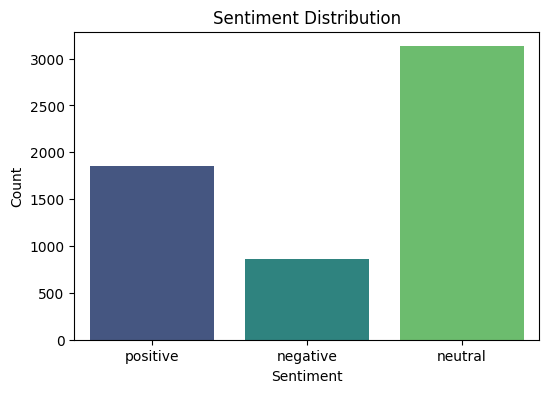

In [6]:
# Create count plot
plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment', data=df, palette='viridis')
# Labels and title
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")
# Show plot
plt.show()

Here the Dataset is imbalenced

# 4.Data Preprocessing

# Label Encoding

In [7]:
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
df["Sentiment_encoded"] = df["Sentiment"].map(label_mapping)


# Splitting into Dependent and Independent Features

In [8]:
x = list(df['Sentence'])
y = np.array(df['Sentiment_encoded'])

# Converting into TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(x).toarray()

# Balencing The Dataset

In [10]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

# Inverse Transform

In [11]:
x_resampled = vectorizer.inverse_transform(X_resampled)
x_resampled = [" ".join(words) for words in x_resampled]

In [12]:
df_new = pd.DataFrame({'Sentence': x_resampled, 'Sentiment_encoded': y_resampled})

In [13]:
df_new.head()

,Sentence,Sentiment_encoded
0,and based benefon by commercial communities co...,2
1,50 bk down esi lows on possibility real to,0
2,2010 componenta doubled earlier eur131m eur76m...,2
3,according all are chamber commerce companies c...,1
4,22 after almost buyout company eighteen finlan...,1


<ipython-input-14-c98da985a074>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_encoded', data=df_new, palette='viridis')


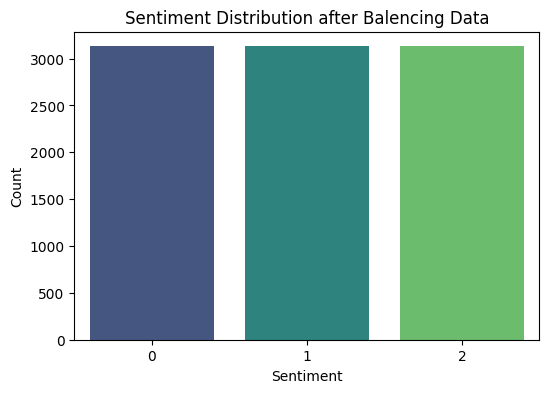

In [14]:

plt.figure(figsize=(6,4))
sns.countplot(x='Sentiment_encoded', data=df_new, palette='viridis')
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution after Balencing Data")
plt.show()

In [16]:
print(y)

[2 0 2 ... 1 1 2]


# Splitting into Train and Test data

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_resampled,y_resampled,test_size=0.2,random_state=0)

# Install Transformers

In [18]:
!pip install transformers

# 5.Loading FinBERT Model and Tokenizer

In [19]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/438M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 6.Build The Model

In [20]:
for layer in model.layers[-10:]:
    layer.trainable = True

In [21]:
train_encodings = tokenizer(x_train, truncation=True, padding=True)
test_encodings = tokenizer(x_test, truncation=True, padding=True )

In [22]:
import tensorflow as tf
train_encodings = {key: tf.convert_to_tensor(val) for key, val in train_encodings.items()}
test_encodings = {key: tf.convert_to_tensor(val) for key, val in test_encodings.items()}

In [23]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": tf.constant(train_encodings["input_ids"]),
        "attention_mask": tf.constant(train_encodings["attention_mask"]),
        "token_type_ids": tf.constant(train_encodings["token_type_ids"]),
    },
    tf.constant(y_train)
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": tf.constant(test_encodings["input_ids"]),
        "attention_mask": tf.constant(test_encodings["attention_mask"]),
        "token_type_ids": tf.constant(test_encodings["token_type_ids"]),
    },
    tf.constant(y_test)
))
train_dataset = train_dataset.shuffle(100).batch(8).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(8).prefetch(tf.data.AUTOTUNE)


# Complie the model

In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

# Fit the model

In [32]:
history = model.fit(train_dataset,
                    epochs=3,
                    batch_size=8,
                    validation_data=test_dataset)

Epoch 1/3
939/939 [==============================] - 207s 177ms/step - loss: 0.1289 - accuracy: 0.9373 - val_loss: 0.7936 - val_accuracy: 0.8253
Epoch 2/3
939/939 [==============================] - 160s 170ms/step - loss: 0.1324 - accuracy: 0.9394 - val_loss: 0.7418 - val_accuracy: 0.8317
Epoch 3/3
939/939 [==============================] - 159s 169ms/step - loss: 0.1160 - accuracy: 0.9413 - val_loss: 0.7862 - val_accuracy: 0.8381


# 7.Evaluating FinBERT Model Performance

In [44]:
test_encodings = tokenizer(x_test, truncation=True, padding=True, return_tensors="tf")
outputs = model.predict(test_encodings)
probs = tf.nn.softmax(outputs.logits, axis=-1).numpy()
y_pred = np.argmax(probs, axis=-1)


59/59 [==============================] - 14s 235ms/step


# Confusion Matrix

59/59 [==============================] - 14s 233ms/step


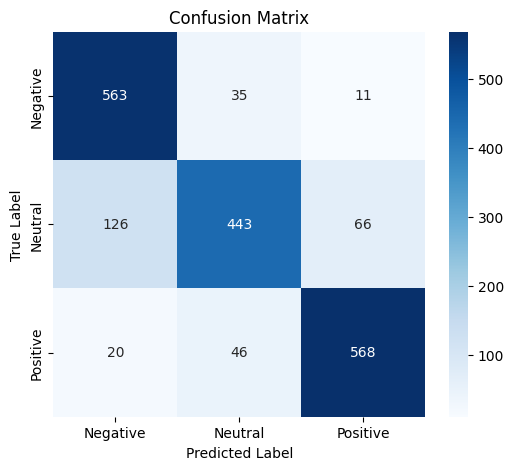

              precision    recall  f1-score   support

    Negative       0.79      0.92      0.85       609
     Neutral       0.85      0.70      0.76       635
    Positive       0.88      0.90      0.89       634

    accuracy                           0.84      1878
   macro avg       0.84      0.84      0.84      1878
weighted avg       0.84      0.84      0.84      1878



In [43]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"]))

The test accuracy is **84%**